In [36]:
import numpy as np
from lab.classifiers.kfingerprinting import ALL_DEFAULT_FEATURES
import pathlib
import pandas as pd
import json
import h5py
import seaborn as sns

feature_names = np.array(ALL_DEFAULT_FEATURES)

In [13]:
log = pathlib.Path("../../results/ml-eval/predictions/tamaraw-dataset/kfp-0.log").read_text()
importances = np.array(json.loads(log.split("\n")[-2].split(" ", 7)[-1]))
importances

array([0.01468417, 0.02678055, 0.02666614, 0.01533522, 0.00901322,
       0.01116361, 0.01408796, 0.01090306, 0.01528026, 0.00796996,
       0.00689189, 0.01389721, 0.01388919, 0.01310146, 0.01455093,
       0.01575731, 0.01353056, 0.01586199, 0.01301131, 0.01183351,
       0.01417237, 0.01321153, 0.01464877, 0.01440886, 0.01237282,
       0.00892051, 0.0089413 , 0.00608539, 0.00561537, 0.00602906,
       0.00713651, 0.00408054, 0.00930789, 0.00555275, 0.00561494,
       0.00974681, 0.00955451, 0.00965022, 0.01078689, 0.00319199,
       0.00878909, 0.00472807, 0.00723397, 0.00152884, 0.01284129,
       0.01196215, 0.00765247, 0.00670203, 0.00652388, 0.00530981,
       0.00483595, 0.00520891, 0.00490981, 0.0044775 , 0.00502263,
       0.00438075, 0.00476692, 0.00427442, 0.0045888 , 0.00435978,
       0.0046674 , 0.00494941, 0.00498481, 0.00454753, 0.00475209,
       0.00381462, 0.0105213 , 0.00734813, 0.00538672, 0.00379952,
       0.00281386, 0.00306068, 0.00340129, 0.00244023, 0.00246

In [29]:
with h5py.File("../../results/ml-eval/features/tamaraw-dataset.h5", mode="r") as h5in:
    features = h5in["kfp"][:]
    classes = h5in["labels"][:]["class"]
features, classes

(array([[3.61580849e-02, 2.02090740e-02, 1.98841095e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.68809700e-02, 2.06139088e-02, 1.99749470e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.60679626e-02, 2.53138542e-02, 1.91099644e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.33421230e-02, 2.51328945e-02, 2.10268497e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.28710079e-02, 2.91130543e-02, 2.16920376e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.40800381e-02, 1.93870068e-02, 1.80819035e-02, ...,
         4.99000000e+02, 4.98000000e+02, 4.98000000e+02]]),
 array([ 0,  0,  0, ..., -1, -1, -1], dtype=int32))

In [40]:
frame = pd.DataFrame(features, index=classes, columns=ALL_DEFAULT_FEATURES)
frame = frame.rename_axis(index="label").reset_index()
frame

,label,interarrival::in::max,interarrival::out::max,interarrival::overall::max,interarrival::in::mean,interarrival::out::mean,interarrival::overall::mean,interarrival::in::std,interarrival::out::std,interarrival::overall::std,...,pps::21,pps::22,pps::23,pps::24,pps::25,pps::26,pps::27,pps::28,pps::29,pps::30
0,0,0.036158,0.020209,0.019884,0.003425,0.003282,0.001675,0.004007,0.003598,0.002511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.036881,0.020614,0.019975,0.003478,0.003315,0.001697,0.004065,0.003631,0.002546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.036068,0.025314,0.019110,0.003430,0.003298,0.001681,0.004013,0.003638,0.002498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.037089,0.021302,0.020248,0.003484,0.003353,0.001708,0.004067,0.003668,0.002562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.036488,0.025395,0.019541,0.002704,0.002616,0.001330,0.001926,0.001320,0.001093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-1,0.039312,0.026228,0.021603,0.004511,0.003312,0.001911,0.002273,0.001563,0.001608,...,515.0,497.0,507.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,-1,0.031293,0.026193,0.020969,0.003627,0.003067,0.001672,0.002653,0.001875,0.001837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,-1,0.033342,0.025133,0.021027,0.004327,0.003303,0.001879,0.002382,0.001703,0.001675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,-1,0.032871,0.029113,0.021692,0.004371,0.003272,0.001876,0.002512,0.001674,0.001535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
top_features = np.flip(importances.argsort()[-10:])
plot_data = frame.iloc[:, np.concatenate(([0], (top_features + 1)))].melt(id_vars="label", var_name="feature")
plot_data = plot_data[plot_data["label"].isin(list(range(10)))]

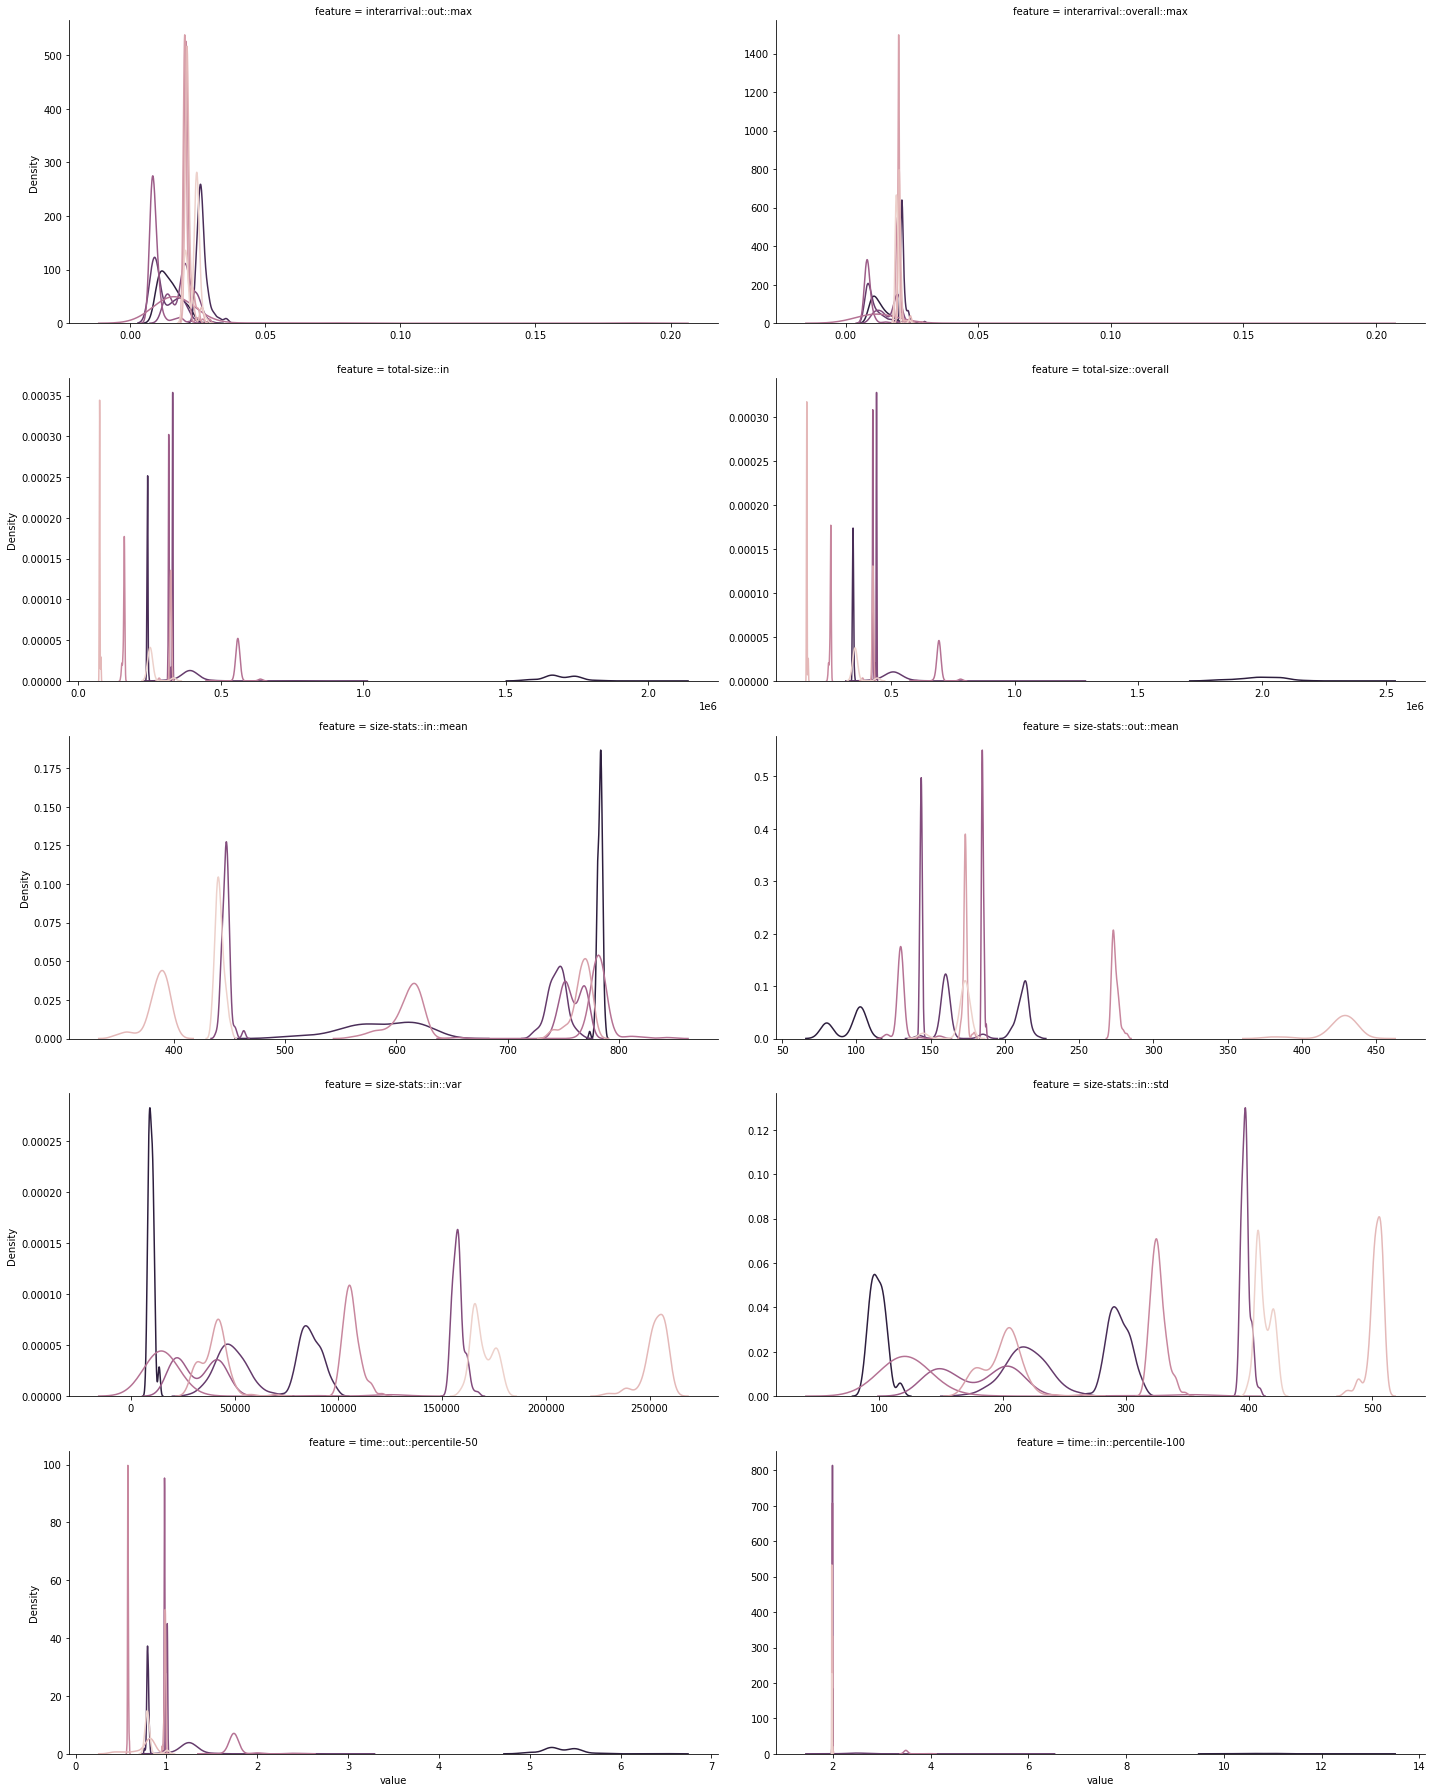

In [71]:
sns.displot(data=plot_data, x="value", hue="label", col="feature", col_wrap=2, kind="kde", legend=False, facet_kws=dict(sharey=False, sharex=False), aspect=2, common_norm=False)

From the above plots, of only 10 labels and the top 10 features the following can be inferred:
- The maximum outgoing and interarrival times are important features. Why?
- Size features, such as total size in and overall, as well as the avg incoming and outgoing packetsizes, and variance and std of the incoming sizes are all important features.
  - The total sizes imply that not enough web-pages are falling into the same length bins (such that the rest does not differentiate the traffic).
  - The average incoming and outgoing packet sizes should not be issues. This however could also be capturing the difference in lengths of the traces, longer traces mean more chaff traffic and acknowledgements which could be reflected in changes to the average packet sizes. THis would also show in the variance and standard deviation.